In [ ]:
# default_exp tslearner

# TSLearners (TSClassifier, TSRegressor, TSForecaster)

> This contains a set of time series learners with a new API that simplifies the learner creation.

In [ ]:
#export
from tsai.imports import *
from tsai.learner import *
from tsai.data.all import *
from tsai.models.InceptionTime import *
from tsai.models.utils import *

## TSClassifier API
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps) with the input time series samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target. Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 80:20 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default:`[None, TSClassification()]` which is commonly used in most single label datasets. 
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Default: InceptionTime.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=accuracy.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training.
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=0. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#export

class TSClassifier(Learner):
    def __init__(self, X, y=None, splits=None, tfms=None, inplace=True, sel_vars=None, sel_steps=None,
                 bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=accuracy, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        #Splits
        if splits is None: splits = TSSplitter()(X)
            
        # Item tfms
        if tfms is None: tfms = [None, TSClassification()]

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, path=path, bs=bs,
                         batch_tfms=batch_tfms, num_workers=num_workers, device=device, shuffle_train=shuffle_train, drop_last=drop_last)
        
        if loss_func is None:
            if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
            elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
            elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
            else: loss_func = CrossEntropyLossFlat()
        
        # Model
        if init is True:
            init = nn.init.kaiming_normal_
        if arch is None:
            arch = InceptionTime
        if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, **arch_config)
        elif 'tabularmodel' in arch.__name__.lower():
            build_tabular_model(arch, dls=dls, device=device, **arch_config)
        else:
            model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                                   exclude_head=exclude_head, cut=cut, init=init, **arch_config)
        setattr(model, "__name__", arch.__name__)
        try:
            model[0], model[1]
            splitter = ts_splitter
        except:
            pass

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

In [ ]:
from tsai.models.InceptionTimePlus import *
X, y, splits = get_classification_data('OliveOil', split_data=False)
batch_tfms = [TSStandardize(by_sample=True)]
learn = TSClassifier(X, y, splits=splits, batch_tfms=batch_tfms, metrics=accuracy, arch=InceptionTimePlus, arch_config=dict(fc_dropout=.5))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.613247,1.415379,0.133333,00:15


/Users/nacho/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


## TSRegressor API
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps) with the input time series samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target. Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 80:20 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=`[None, TSRegression()]` which is commonly used in most single label datasets. 
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Default: InceptionTime.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=None.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training.
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=0. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#export
 
        
class TSRegressor(Learner):
    def __init__(self, X, y=None, splits=None, tfms=None, inplace=True, sel_vars=None, sel_steps=None, 
                 bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        #Splits
        if splits is None: splits = TSSplitter()(X)
            
        # Item tfms
        if tfms is None: tfms = [None, TSRegression()]

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, path=path, bs=bs,
                         batch_tfms=batch_tfms, num_workers=num_workers, device=device, 
                         shuffle_train=shuffle_train, drop_last=drop_last)

        if loss_func is None:
            if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
            elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
            elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
            else: loss_func = MSELossFlat()
                
        # Model
        if init is True:
            init = nn.init.kaiming_normal_
        if arch is None:
            arch = InceptionTime
        if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, **arch_config)
        elif 'tabularmodel' in arch.__name__.lower():
            build_tabular_model(arch, dls=dls, device=device, **arch_config)
        else:
            model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                               exclude_head=exclude_head, cut=cut, init=init, **arch_config)
        setattr(model, "__name__", arch.__name__)
        try:
            model[0], model[1]
            splitter = ts_splitter
        except:
            pass

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)      

In [ ]:
from tsai.models.TST import *
X, y, splits = get_regression_data('AppliancesEnergy', split_data=False)
batch_tfms = [TSStandardize()]
learn = TSRegressor(X, y, splits=splits, batch_tfms=batch_tfms, arch=TST, metrics=mae, bs=512)
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,mae,time
0,207.246979,192.114578,13.426781,00:15


## TSForecaster API
***
**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps) with the input time series samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target. Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 80:20 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=`[None, TSForecasting()]` which is commonly used in most single label datasets. 
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Default: InceptionTime.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=None.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training.
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=None. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#export  
        
class TSForecaster(Learner):
    def __init__(self, X, y=None, splits=None, tfms=None, inplace=True, sel_vars=None, sel_steps=None, 
                 bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        #Splits
        if splits is None: splits = TSSplitter()(X)
            
        # Item tfms
        if tfms is None: tfms = [None, TSForecasting()]

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, path=path, bs=bs,
                         batch_tfms=batch_tfms, num_workers=num_workers, device=device, 
                         shuffle_train=shuffle_train, drop_last=drop_last)
        
        if loss_func is None:
            if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
            elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
            elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
            else: loss_func = MSELossFlat()
        
        # Model
        if init is True:
            init = nn.init.kaiming_normal_
        if arch is None:
            arch = InceptionTime
        if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, **arch_config)
        elif 'tabularmodel' in arch.__name__.lower():
            build_tabular_model(arch, dls=dls, device=device, **arch_config)
        else:
            model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                               exclude_head=exclude_head, cut=cut, init=init, **arch_config)
        setattr(model, "__name__", arch.__name__)
        try:
            model[0], model[1]
            splitter = ts_splitter
        except:
            pass

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

In [ ]:
from tsai.models.TSTPlus import *
ts = get_forecasting_time_series('Sunspots')

Dataset: Sunspots
downloading data...
...data downloaded. Path = data/forecasting/Sunspots.csv


Dataset: Sunspots
downloading data...
...data downloaded. Path = data/forecasting/Sunspots.csv


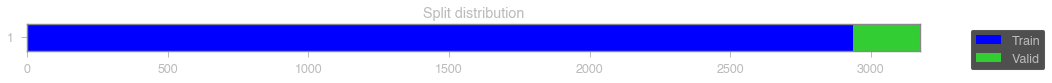

epoch,train_loss,valid_loss,mae,time
0,10794.725586,6287.113770,58.876122,01:27


In [ ]:
from tsai.models.TSTPlus import *
ts = get_forecasting_time_series('Sunspots')
X, y = SlidingWindowSplitter(60, horizon=1)(ts)
splits = TSSplitter(235)(y)
batch_tfms = [TSStandardize(by_var=True)]
learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=TST, arch_config=dict(fc_dropout=.5), metrics=mae, bs=512)
learn.fit_one_cycle(1)

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.